#   LangGraph 활용 - 사용자 개입 (Human-in-the-Loop)

---

## 환경 설정 및 준비

`(1) Env 환경변수`

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

`(2) 기본 라이브러리`

In [2]:
import os
from glob import glob

from pprint import pprint
import json

`(3) Langsmith tracing 설정`

In [3]:
# Langsmith tracing 여부를 확인 (true: langsmith 추적 활성화, false: langsmith 추적 비활성화)
import os
print(os.getenv('LANGSMITH_TRACING'))

true


---

## **Human-in-the-Loop (사용자 개입)**

- **HITL**는 AI 시스템에 인간의 판단과 전문성을 통합

- **Breakpoints**로 특정 단계에서 실행 중지 가능
    - **Breakpoint**는 LangGraph의 **체크포인트 기능** 기반으로 작동하는 시스템
    - 각 노드 실행 후 그래프의 상태를 **스레드에 저장**하여 나중에도 접근 가능
    - 그래프 실행을 특정 지점에서 **일시 중지**하고 사용자 승인 후 재개 가능

- 사용자의 **입력**이나 **승인**을 기다리는 패턴으로 작동

- 시스템 결정에 대한 **인간의 통제**와 **검증** 보장

`(1) 문서 생성 및 검토 시스템`

- **문서 생성** 단계에서 AI가 초안 작성
- **검토 단계**에서 인간 전문가가 내용 검증
- **수정 요청**시 AI가 피드백 반영하여 개선

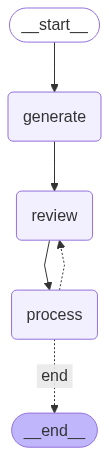

In [ ]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import interrupt
from langgraph.checkpoint.memory import InMemorySaver
from langchain_core.messages import HumanMessage, AIMessage
from IPython.display import Image, display

# 상태 정의 
class State(MessagesState):
    draft: str     # 초안
    feedback: str  # 피드백

def generate_draft(state: State):
    """초안 생성"""
    draft = "이것은 AI가 생성한 문서 초안입니다.\n\n내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다."
    return {
        "draft": draft,
        "messages": [AIMessage(content=f"초안이 생성되었습니다:\n\n{draft}")]
    }

def review_draft(state: State):
    """초안 검토 - interrupt를 사용하여 사용자 입력 대기"""
    # 사용자에게 검토를 요청하고 응답을 기다림
    user_decision = interrupt({
        "action": "review_document",
        "draft": state["draft"],
        "question": "이 문서를 승인하시겠습니까? '승인' 또는 수정 요청 사항을 입력해주세요."
    })

    # 사용자 입력을 출력
    print(f"사용자 입력: {user_decision}")
    
    # 사용자 입력을 feedback으로 저장
    return {
        "feedback": user_decision,
        "messages": [AIMessage(content=f"사용자 피드백을 받았습니다: {user_decision}")]
    }

def process_feedback(state: State):
    """피드백 처리"""
    feedback = state.get("feedback", "").lower()
    
    if "승인" in feedback:
        return {
            "messages": [AIMessage(content="✅ 문서가 승인되었습니다. 워크플로우가 완료되었습니다.")]
        }
    else:
        # 피드백에 따라 문서 수정
        revised_draft = f"{state['draft']}\n\n[수정사항 반영]\n피드백: {state['feedback']}\n수정된 내용이 반영되었습니다."
        return {
            "draft": revised_draft,
            "messages": [AIMessage(content=f"문서를 수정하였습니다.\n\n피드백: {state['feedback']}\n\n수정된 초안:\n{revised_draft}")]
        }

def should_continue(state: State):
    """계속 진행 여부 결정"""
    feedback = state.get("feedback", "").lower()
    if "승인" in feedback:
        return "end"
    else:
        return "review"  # 다시 검토로 돌아감

# 그래프 설정
builder = StateGraph(State)

# 노드 추가
builder.add_node("generate", generate_draft)
builder.add_node("review", review_draft)
builder.add_node("process", process_feedback)

# 엣지 추가
builder.add_edge(START, "generate")
builder.add_edge("generate", "review")
builder.add_edge("review", "process")
builder.add_conditional_edges(
    "process",
    should_continue,
    {
        "review": "review",
        "end": END
    }
)

# Checkpointer 설정 (interrupt 사용을 위해 필수)
checkpointer = InMemorySaver()

# 그래프 컴파일
graph = builder.compile(checkpointer=checkpointer)

# 그래프 시각화
display(Image(graph.get_graph().draw_mermaid_png()))

`(2) 워크플로우 시작`

- **interrupt**까지 실행


In [5]:
# 최초 메시지 및 스레드 설정 
config = {"configurable": {"thread_id": "1"}}
initial_input = {"messages": []}

# 첫 번째 실행 - 중단점에서 실행을 멈춤 
for event in graph.stream(initial_input, config):
    print(f"Event: {event}")

Event: {'generate': {'draft': '이것은 AI가 생성한 문서 초안입니다.\n\n내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다.', 'messages': [AIMessage(content='초안이 생성되었습니다:\n\n이것은 AI가 생성한 문서 초안입니다.\n\n내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다.', additional_kwargs={}, response_metadata={}, id='380e18e4-5057-4fc2-abb3-16c2a3ae352e')]}}
Event: {'__interrupt__': (Interrupt(value={'action': 'review_document', 'draft': '이것은 AI가 생성한 문서 초안입니다.\n\n내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다.', 'question': "이 문서를 승인하시겠습니까? '승인' 또는 수정 요청 사항을 입력해주세요."}, resumable=True, ns=['review:7335cd1e-9696-b24f-f7f8-58f5524caa76']),)}


`(3) 현재 상태 확인`

- **get_state** 함수로 현재 상태 확인 가능


In [6]:
# 현재 상태 - 그래프 체크포인트 확인
current_state = graph.get_state(config)

print(f"\n현재 상태: {current_state.values}")
print(f"대기 중인 interrupt: {current_state.tasks}")


현재 상태: {'messages': [AIMessage(content='초안이 생성되었습니다:\n\n이것은 AI가 생성한 문서 초안입니다.\n\n내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다.', additional_kwargs={}, response_metadata={}, id='380e18e4-5057-4fc2-abb3-16c2a3ae352e')], 'draft': '이것은 AI가 생성한 문서 초안입니다.\n\n내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다.'}
대기 중인 interrupt: (PregelTask(id='7335cd1e-9696-b24f-f7f8-58f5524caa76', name='review', path=('__pregel_pull', 'review'), error=None, interrupts=(Interrupt(value={'action': 'review_document', 'draft': '이것은 AI가 생성한 문서 초안입니다.\n\n내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다.', 'question': "이 문서를 승인하시겠습니까? '승인' 또는 수정 요청 사항을 입력해주세요."}, resumable=True, ns=['review:7335cd1e-9696-b24f-f7f8-58f5524caa76']),), state=None, result=None),)


In [7]:
# 대기 중인 interrupt 확인
task = current_state.tasks[0]
print(task.id)
print(task.name)
pprint(task.interrupts[0].value)

7335cd1e-9696-b24f-f7f8-58f5524caa76
review
{'action': 'review_document',
 'draft': '이것은 AI가 생성한 문서 초안입니다.\n\n내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다.',
 'question': "이 문서를 승인하시겠습니까? '승인' 또는 수정 요청 사항을 입력해주세요."}


In [8]:
# 다음에 실행될 노드를 확인 
current_state.next

('review',)

`(4) 사용자 개입 (HITL): 거부`

- 사용자가 승인을 해주지 않는 경우, 피드백을 통해 다시 생성
- **Command** 함수로 사용자 피드백 전달

In [9]:
from langgraph.types import Command

# 사용자 피드백 제공 (거부)
human_feedback = "문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요."

# 사용자 입력으로 그래프 재개
for event in graph.stream(Command(resume=human_feedback), config=config):
    print(f"Event: {event}")

사용자 입력: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.
Event: {'review': {'feedback': '문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.', 'messages': [AIMessage(content='사용자 피드백을 받았습니다: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.', additional_kwargs={}, response_metadata={}, id='97fb3327-1774-46f3-b5b6-442d93868436')]}}
Event: {'process': {'draft': '이것은 AI가 생성한 문서 초안입니다.\n\n내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다.\n\n[수정사항 반영]\n피드백: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.\n수정된 내용이 반영되었습니다.', 'messages': [AIMessage(content='문서를 수정하였습니다.\n\n피드백: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.\n\n수정된 초안:\n이것은 AI가 생성한 문서 초안입니다.\n\n내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다.\n\n[수정사항 반영]\n피드백: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.\n수정된 내용이 반영되었습니다.', additional_kwargs={}, response_metadata={}, id='e83130fc-d8ef-428d-86c4-1b53380e1523')]}}
Event: {'__interrupt__': (Interrupt(value={'action': 'review_document', 'draft': '이것은 AI가 생성한 문서 초안입니다.\n\n내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다.\n\n[수정사항 반영]\n피드백: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가

In [10]:
# 현재 상태 - 그래프 체크포인트 확인
current_state = graph.get_state(config)

print(f"\n현재 상태: {current_state.values}")
print(f"대기 중인 interrupt: {current_state.tasks}")


현재 상태: {'messages': [AIMessage(content='초안이 생성되었습니다:\n\n이것은 AI가 생성한 문서 초안입니다.\n\n내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다.', additional_kwargs={}, response_metadata={}, id='380e18e4-5057-4fc2-abb3-16c2a3ae352e'), AIMessage(content='사용자 피드백을 받았습니다: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.', additional_kwargs={}, response_metadata={}, id='97fb3327-1774-46f3-b5b6-442d93868436'), AIMessage(content='문서를 수정하였습니다.\n\n피드백: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.\n\n수정된 초안:\n이것은 AI가 생성한 문서 초안입니다.\n\n내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다.\n\n[수정사항 반영]\n피드백: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.\n수정된 내용이 반영되었습니다.', additional_kwargs={}, response_metadata={}, id='e83130fc-d8ef-428d-86c4-1b53380e1523')], 'draft': '이것은 AI가 생성한 문서 초안입니다.\n\n내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다.\n\n[수정사항 반영]\n피드백: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.\n수정된 내용이 반영되었습니다.', 'feedback': '문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.'}
대기 중인 interrupt: (PregelTask(id='5857f179-4173-32d9-51a8-30fd95750415', name='review', path=('__pregel_p

In [11]:
# 대기 중인 interrupt 확인
task = current_state.tasks[0]
print(task.id)
print(task.name)
pprint(task.interrupts[0].value)

5857f179-4173-32d9-51a8-30fd95750415
review
{'action': 'review_document',
 'draft': '이것은 AI가 생성한 문서 초안입니다.\n'
          '\n'
          '내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다.\n'
          '\n'
          '[수정사항 반영]\n'
          '피드백: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.\n'
          '수정된 내용이 반영되었습니다.',
 'question': "이 문서를 승인하시겠습니까? '승인' 또는 수정 요청 사항을 입력해주세요."}


In [12]:
# 다음에 실행될 노드를 확인 
current_state.next

('review',)

`(5) 사용자 개입 (HITL): 승인`

- 사용자가 '승인'을 해서 최종 답변을 생성하고 종료

In [13]:
from langgraph.types import Command

# 사용자 피드백 제공 (승인 문자열을 사용)
human_feedback = "승인합니다."

# 사용자 입력으로 그래프 재개
for event in graph.stream(Command(resume=human_feedback), config=config):
    print(f"Event: {event}")

사용자 입력: 승인합니다.
Event: {'review': {'feedback': '승인합니다.', 'messages': [AIMessage(content='사용자 피드백을 받았습니다: 승인합니다.', additional_kwargs={}, response_metadata={}, id='257a9136-5f8c-43e8-b794-11c1345ecec7')]}}
Event: {'process': {'messages': [AIMessage(content='✅ 문서가 승인되었습니다. 워크플로우가 완료되었습니다.', additional_kwargs={}, response_metadata={}, id='3f04ffc1-93e6-4a12-b8c6-34ace783744f')]}}


In [14]:
# 현재 상태 - 그래프 체크포인트 확인
current_state = graph.get_state(config)

print(f"\n현재 상태: {current_state.values}")
print(f"대기 중인 interrupt: {current_state.tasks}")


현재 상태: {'messages': [AIMessage(content='초안이 생성되었습니다:\n\n이것은 AI가 생성한 문서 초안입니다.\n\n내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다.', additional_kwargs={}, response_metadata={}, id='380e18e4-5057-4fc2-abb3-16c2a3ae352e'), AIMessage(content='사용자 피드백을 받았습니다: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.', additional_kwargs={}, response_metadata={}, id='97fb3327-1774-46f3-b5b6-442d93868436'), AIMessage(content='문서를 수정하였습니다.\n\n피드백: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.\n\n수정된 초안:\n이것은 AI가 생성한 문서 초안입니다.\n\n내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다.\n\n[수정사항 반영]\n피드백: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.\n수정된 내용이 반영되었습니다.', additional_kwargs={}, response_metadata={}, id='e83130fc-d8ef-428d-86c4-1b53380e1523'), AIMessage(content='사용자 피드백을 받았습니다: 승인합니다.', additional_kwargs={}, response_metadata={}, id='257a9136-5f8c-43e8-b794-11c1345ecec7'), AIMessage(content='✅ 문서가 승인되었습니다. 워크플로우가 완료되었습니다.', additional_kwargs={}, response_metadata={}, id='3f04ffc1-93e6-4a12-b8c6-34ace783744f')], 'draft': '이것은 AI가 생성한 문서 초안입니다.\n\n내

In [15]:
# 대기 중인 interrupt 확인
current_state.tasks

()

In [16]:
# 최종 상태 확인
current_state.values

{'messages': [AIMessage(content='초안이 생성되었습니다:\n\n이것은 AI가 생성한 문서 초안입니다.\n\n내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다.', additional_kwargs={}, response_metadata={}, id='380e18e4-5057-4fc2-abb3-16c2a3ae352e'),
  AIMessage(content='사용자 피드백을 받았습니다: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.', additional_kwargs={}, response_metadata={}, id='97fb3327-1774-46f3-b5b6-442d93868436'),
  AIMessage(content='문서를 수정하였습니다.\n\n피드백: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.\n\n수정된 초안:\n이것은 AI가 생성한 문서 초안입니다.\n\n내용: 인공지능 기술의 발전과 활용 방안에 대한 보고서입니다.\n\n[수정사항 반영]\n피드백: 문서 내용이 너무 간단합니다. 배경과 목적에 대한 내용을 추가해주세요.\n수정된 내용이 반영되었습니다.', additional_kwargs={}, response_metadata={}, id='e83130fc-d8ef-428d-86c4-1b53380e1523'),
  AIMessage(content='사용자 피드백을 받았습니다: 승인합니다.', additional_kwargs={}, response_metadata={}, id='257a9136-5f8c-43e8-b794-11c1345ecec7'),
  AIMessage(content='✅ 문서가 승인되었습니다. 워크플로우가 완료되었습니다.', additional_kwargs={}, response_metadata={}, id='3f04ffc1-93e6-4a12-b8c6-34ace783744f')],
 'draft': '이것은 AI가 생성한 문서 초안입니다.\n\n

In [17]:
# 다음에 실행될 노드를 확인 
current_state.next

()

# ~ 17:24분까지 실습